In [76]:
from sklearn import model_selection, datasets, svm
from qiskit import QuantumCircuit, Aer, IBMQ, QuantumRegister, ClassicalRegister
import qiskit
import numpy as np
import copy
import matplotlib.pyplot as plt

In [77]:
iris = datasets.load_iris()
X = iris.data[0:100]
Y = iris.target[0:100]
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.33, random_state=42)

In [78]:
print(Y_train)

[0 1 0 1 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 1
 1 0 1 0 1 1 1 0 1 1 1 1 0 0 0 1 0 0 0 1 1 1 1 1 0 1 1 0 1 1]


In [79]:
print(X_train[0])

[5.2 3.4 1.4 0.2]


In [80]:
N = 4 

In [81]:
def feature_map(X) :
    q = QuantumRegister(N)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q,c)
    
    for i, x in enumerate(X) :
        qc.rx(x, i)
        
    return qc, c

In [82]:
def variational_circuit(qc, theta):
    
    for i in range(N-1):
        qc.cnot(i, i+1)
    qc.cnot(N-1, 0)
    for i in range(N):
        qc.ry(theta[i], i)
    return qc
        

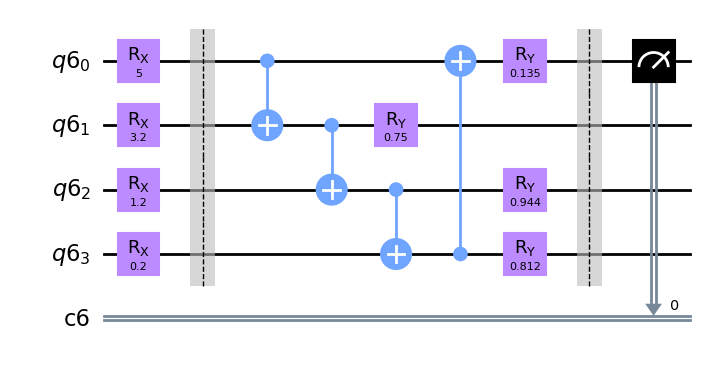

In [83]:
def quantum_nn(X, theta, simulator=True):
    
    qc, c = feature_map(X)
    qc = variational_circuit(qc, theta)
    qc.measure(0,c)
    
    shots = 1E4
    backend = Aer.get_backend('qasm_simulator')
    
    if simulator == False:
        
        shots = 5000
        provider = IBMQ.load_account()
        backend = provider.get_backend('ibmq_athens')
        
    job = qiskit.execute(qc, backend, shots=shots)
    result = job.result()
    counts = result.get_counts(qc)
    
    return(counts['1']/shots)

qc.draw('mpl')

In [84]:
def loss (prediction, target):
    return (prediction - target)**2

In [85]:
def gradient(X, Y, theta):
    
    delta = 0.01
    grad = []
    for i in range(len(theta)):
        
        dtheta = copy.copy(theta)
        dtheta[i] += delta
        
        pred1 = quantum_nn(X, dtheta)
        pred2 = quantum_nn(X, theta)
        
        grad.append((loss(pred1, Y) - loss(pred2, Y)) / delta)
        
    return np.array(grad)

In [86]:
def accuracy(X, Y, theta):
    
    counter = 0
    for X_i, Y_i in zip(X, Y):
        
        prediction = quantum_nn(X_i, theta)
        
        if prediction < 0.5 and Y_i == 0:
            counter += 1
        elif prediction >= 0.5 and Y_i == 1:
            counter += 1
            
    return counter/len(Y)

In [87]:
eta = 0.05
loss_list = []
theta = np.ones(N)

print('Epoch \t Loss \t Training Accuracy')

for i in range(20):
    
    loss_tmp = []
    for X_i, Y_i in zip(X_train, Y_train):

        prediction = quantum_nn(X_i, theta)
        loss_tmp.append(loss(prediction, Y_i))
        theta = theta - eta * gradient(X_i, Y_i, theta)
        
    loss_list.append(np.mean(loss_tmp))
    acc = accuracy(X_train, Y_train, theta)
    
    print(f'{i} \t {loss_list[-1]:.3f} \t {acc:.3f}')

Epoch 	 Loss 	 Training Accuracy
0 	 0.273 	 0.224
1 	 0.243 	 0.866
2 	 0.213 	 0.851
3 	 0.208 	 0.776
4 	 0.207 	 0.821
5 	 0.206 	 0.836
6 	 0.202 	 0.836
7 	 0.201 	 0.806
8 	 0.202 	 0.821
9 	 0.200 	 0.836
10 	 0.201 	 0.806
11 	 0.201 	 0.851
12 	 0.202 	 0.836
13 	 0.202 	 0.821
14 	 0.201 	 0.821
15 	 0.202 	 0.851
16 	 0.200 	 0.821
17 	 0.202 	 0.821
18 	 0.201 	 0.806
19 	 0.202 	 0.806


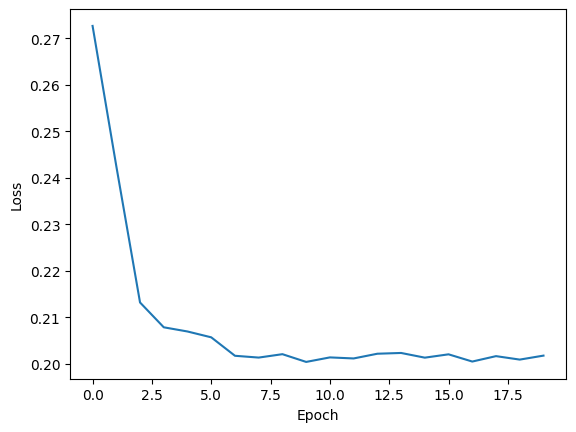

In [88]:
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [89]:
accuracy(X_test, Y_test, theta)

0.7575757575757576

In [90]:
clf = svm.SVC()
clf.fit(X_train, Y_train)

SVC()

In [91]:
print(clf.predict(X_test))
print(Y_test)

[1 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0 0 1 0 1 0 0 1]
[1 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0 0 1 0 1 0 0 1]
